This notebook serves to reproduce the experiments done in the main paper, and detailed in appendix B.

In [1]:
import torch as t
t.set_num_threads(8)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from train import train
from models import Transformer, Low_rank, AoT
from utils import generate_data, entropy, power_unif_law
from tqdm import tqdm

The cell below is used to train a single AoT or Transformer, and plot the loss and accuracy. 
A sequence encoder is also trained as a comparison for what the Transformer can achieve at most.

100%|██████████| 4/4 [03:58<00:00, 59.71s/it]


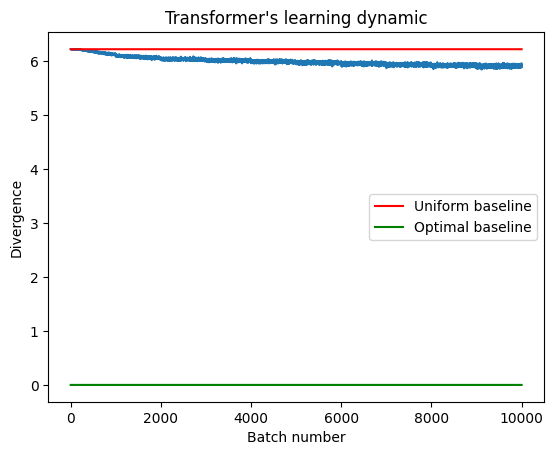

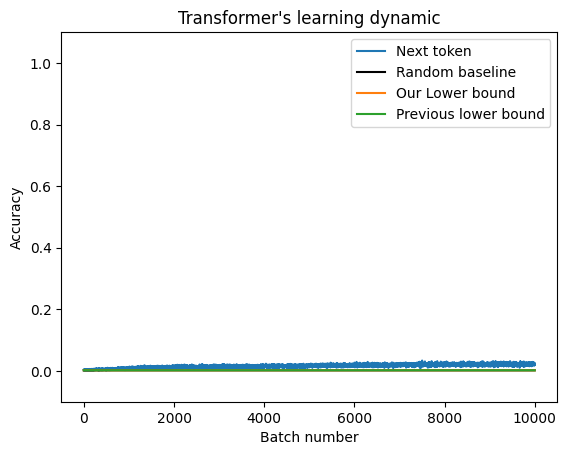

In [2]:
"""Training a Transformer."""
t.manual_seed(2222)

# Transformer parameters.
N = 500
d = 50
nb_layers = 1
width = 0
para = 11
d_head = 50
nb_head = 1         # This is the number of head per attention module, thus d_head%nb_head = 0.
n_gram = 4
context_window = n_gram

# Distribution parameters. Each distribution level is a power law alpha over some tokens. 
# The parameter nb_tokens says how many tokens are non-zero at each step. 
alphas = [1, 1, 1]
nb_tokens=[N, N, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Learning parameters for the Transformer.
batch_size=2**10
num_batch=1000
epoches=10
lr=1e-3
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Training the Transformer.
model = Transformer(d, N, nb_layers, width, para, d_head, nb_head, context_window, pi)
Dict = train(model, Data, epoches, lr=lr, next_token=True)
plt.plot(Dict['Loss'])

# Upper bound: we compute the divergence with the uniform predictor.
ent=entropy(pi)
plt.plot([np.log(N)-ent for _ in Dict['Loss']], label='Uniform baseline', color='red')

# Learning parameters for the sequence encoder.
low_batch_size=2**10
low_num_batch=1000*2
low_lr=1e-3
epochs=4

# Lower bound: we compute the best Sequence encoder, the diverge of which sets the attainable lower bound.
model_low = Low_rank(d, N, context_window, pi)
Data = generate_data(low_batch_size, low_num_batch, pi, context_window)
dict_low = train(model_low, Data, epochs, lr=low_lr)
best_loss = sum(dict_low['Loss'][-101:-1])/100
plt.plot([best_loss for _ in Dict['Loss']], label='Optimal baseline', color='green')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Divergence")
plt.title("Transformer's learning dynamic")
plt.show()

# We plot the accuracy of the Transformer, the accuracy of the random predictor, 
# and the lower bound from are paper as well as the previous sota bound (in accuracy, not in worst-case).
plt.plot(Dict['Acc'], label=f'Next token')
plt.plot([1/N for _ in Dict['Acc']], color='black', label='Random baseline')
if width == 0: # Put the lower bounds only if we are training and AoT.
    plt.plot([1/N+(1-1/N)*para*d_head/(N**(n_gram-1)) for _ in Dict['Acc']], label='Our Lower bound')
    plt.plot([1/N+(1-1/N)*(para*(d_head-1)+1)/(N**(n_gram-1)) for _ in Dict['Acc']], label='Previous lower bound')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.ylim(top=1+0.1, bottom=0-0.1)
plt.title("Transformer's learning dynamic")
plt.show()

# Experiments

Execute the cells below to produce the data obtained in the folder Scaling laws. Experiments 1 to 4 are done exclusively on AoT, while experiment 5 involves general Transformers.

**Experiment 1**: we test the scaling in the variable $H$ (or *para* in the notebook), which is the number of heads.
Result: the scaling is found to be linear, as expected.

**Experiment 2**: we test the scaling of the variable $d_{h}$, which is the dimension of each head.
Result: the scaling is linear as expected.

**Experiment 3**: we test the scaling of the variable $d$, which is the embedding dimension.
Result: the scaling is linear by part, being separated at $d=d_{h}$. The second linear scale is noisy, meaning that this might be an optimization issue.

**Experiment 4**: we test the scaling of $d=d_h$, when heads have the same dimension as the residual stream. (The data used in experiment 4 is the same as experiment 1.)
Result: We find a scaling which is cubic. The scaling as expected to be at least quadratic, using the results from experiment 2 and 3. The scaling being cubic might suggest that experiment 3 had indeed optimization issues, which were uplifted by taking $d=d_h$.

**Experiment 5**: we test the scaling of a Transformer with one attention head, and an MLP with varying width.
Result: we find that the accuracy, by parameter, of both the AoT and the MLP-based Transformer are equivalent.

**Experiement 6**: we test the scaling in the setting of Corollary 1, with $d=2$. We find that our solution in that case is not optimal as the observed scaling is greater.

In [ ]:
""" Experiment 1. Scaling laws on H and d=d_head. """
t.manual_seed(2222)

# Model parameters.
N = 50
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10
repetition = 2
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Scaling parameters
min_para=1
max_para=31
para_step=5
min_d=3
max_d=13
d_step=1

for i, d in enumerate(range(min_d, max_d+1, d_step)):
    d_head=d 

    mean_accuracy = []
    para_list = []
    N_list = []
    d_list = []
    d_head_list = []

    for para in tqdm(range(min_para, max_para+1, para_step)):
        accuracy = 0

        for _ in range(repetition):
            model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

            dict = train(model, Data, epochs, lr=lr, next_token=True)
            acc = sum(dict['Acc'][-101:-1])/100
            
            accuracy += acc

        mean_accuracy.append(accuracy/repetition)
        N_list.append(N)
        d_list.append(d)
        d_head_list.append(d_head)
        para_list.append(para)

    results = {
        'acc': mean_accuracy,
        'para': para_list,
        'N': N_list,
        'd': d_list,
        'd_head': d_head_list,
    }

    # We save the results as a dataframe.
    data = pd.DataFrame(results)
    data.to_csv(f'Scaling laws/Data_exp_1_{i}.csv', index=False)

In [ ]:
""" Experiment 2. Scaling laws on d_head, with d!=d_head and H (=para) fixed. """
t.manual_seed(2222)

# Model parameters.
N = 50
d = 10
para = 20
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10
repetition = 2
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Scaling parameters
min_d_head = 1
max_d_head = d
d_head_step = 1

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []
for d_head in tqdm(range(min_d_head, max_d_head+1, d_head_step)):
    accuracy = 0

    for _ in range(repetition):
        model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
        
        accuracy += acc

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Data_exp_2.csv', index=False)

In [2]:
""" Experiment 3. Scaling laws on  d, with d_head and H (=para) fixed. """
t.manual_seed(3333)

# Model parameters.
N = 50
d_head = 10
para = 20
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10
repetition = 2
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Scaling parameters
min_d = 5
max_d = 15
d_step = 1

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []
for d in tqdm(range(min_d, max_d+1, d_step)):
    accuracy = 0

    for _ in range(repetition):
        model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
            
        accuracy += acc

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Data_exp_3.csv', index=False)

100%|██████████| 11/11 [8:27:05<00:00, 2765.93s/it]  


In [ ]:
""" Experiment 5. Scaling laws on the width of Transformer using MLPs. """
t.manual_seed(3333)

# Model parameters.
N = 50
para = 1
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10
repetition = 2
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

for d, exp_num in zip([5, 7, 10, 13], [2, 4, 7, 10]):
    d_head = d
    min_width = 2*d*(1-1)
    max_width = 2*d*(26-1)
    step = 2*d*5

    mean_accuracy = []
    para_list = []
    N_list = []
    d_list = []
    d_head_list = []
    width_list = []
    for width in tqdm(range(min_width, max_width+1, step)):
        accuracy = 0

        for _ in range(repetition):
            model = Transformer(d, N, nb_layers, width, para, d_head, nb_head, context_window, pi)

            dict = train(model, Data, epochs, lr=lr, next_token=True)
            acc = sum(dict['Acc'][-101:-1])/100
            
            accuracy += acc
            print(accuracy)

        mean_accuracy.append(accuracy/repetition)
        N_list.append(N)
        d_list.append(d)
        d_head_list.append(d_head)
        para_list.append(para)
        width_list.append(width)

    results = {
        'acc': mean_accuracy,
        'para': para_list,
        'N': N_list,
        'd': d_list,
        'd_head': d_head_list,
        'width': width_list,
    }

    # We save the results as a dataframe.
    data = pd.DataFrame(results)
    data.to_csv(f'Scaling laws/Data_exp_5_{exp_num}.csv', index=False)

In [ ]:
""" Experiment 6. Scaling laws on H with N=10, d=2, d_head=5. """
t.manual_seed(2222)

# Model parameters.
N = 10
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]
pi = power_unif_law(alphas, nb_tokens, N)

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=15
repetition = 3
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Scaling parameters
min_para=1
max_para=21
para_step=4
d=2
d_head=5
d_step=1

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []

for para in tqdm(range(min_para, max_para+1, para_step)):
    accuracy = 0

    for _ in range(repetition):
        model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
            
        accuracy += acc

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Data_exp_6.csv', index=False)